(a) Simulate the performance of Alamouti two-antenna transmit diversity. Create a random stream of, say, 1000 QPSK symbols $(±1 ± j)/√2$. Generate a sequence of channel matrices by moving the receiver (or transmitter) through a multipath environment slowly enough that the slow fading assumption holds, but fast enough that the channel is random over the whole simulation. Generate complex Gaussian noise with variance $σ^2_η$ to simulate noise at the receiver. Assuming the receiver knows the channel perfectly, detect the symbols using the Alamouti scheme. Compute the symbol error rate as the ratio of incorrectly decoded symbols to the total number of symbols. Repeat for different values of SNR, and plot the symbol error rate on a log scale as a function of SNR in dB.

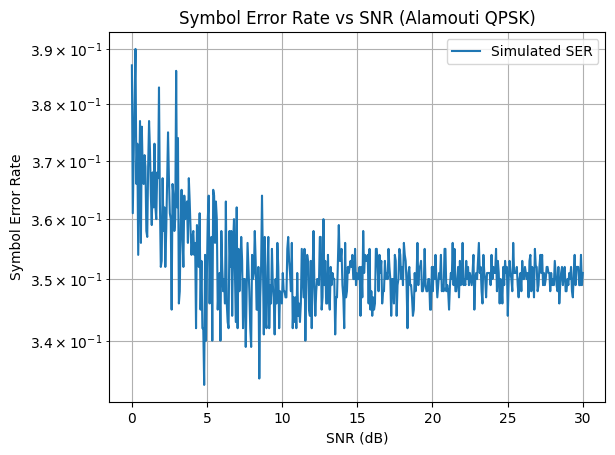

In [59]:
# Scatterer multipath propagation model
import numpy as np
import matplotlib.pyplot as plt

# same quadrant helper function
def same_quadrant(a, b):
    return (np.sign(a.real) == np.sign(b.real) and np.sign(a.imag) == np.sign(b.imag))

# parameters
f = 1e9         # frequency
c0 = 3e8        # speed of light
lam = c0/f      # wavelength
k = 2*np.pi/lam # wavenumber
eta = 377       # impedance of free space

# Create a random stream of 1000 QPSK symbols (±1 ± j)/√2
num_symbols = 1000
bits_i = np.random.randint(0, 2, num_symbols)   # in-phase bits
bits_q = np.random.randint(0, 2, num_symbols)   # quadrature bits
symbols_i = (2*bits_i - 1)/np.sqrt(2)           # in-phase symbols
symbols_q = (2*bits_q - 1)/np.sqrt(2)           # quadrature symbols
qpsk_symbols = symbols_i + 1j*symbols_q         # complex symbols
qpsk_symbols = qpsk_symbols[:2 * (num_symbols // 2)]  # Make it even
qpsk_blocks = qpsk_symbols.reshape(-1, 2)  # Shape: [num_blocks, 2]
num_blocks = qpsk_blocks.shape[0]

# Simulate the performance of Alamouti two-antenna transmit diversity
points = num_blocks                 # number of points to simulate
Nt = 2                              # transmit antennas
Nr = 1                              # receive antennas
d = 0.4*lam                         # element spacing
x_t = 0                             # transmitter location in x direction
y_t = 0                             # transmitter location in y direction
x_r = np.linspace(-10, 10, points)  # moving receiver locations in x direction
y_r = np.zeros(points)              # static receiver locations in y direction

# Generate a sequence of channel matrices by moving the receiver (or transmitter)
# through a multipath environment. 
x_s = np.random.uniform(-10, 10, points)    # x-coordinates of scatterers
y_s = np.random.uniform(-10, 10, points)    # y-coordinates of scatterers
ref_coef = -1                               # reflection coefficient


# calculate an array of channel matrices
H = np.zeros([points, Nt, Nr], dtype=complex)   # channel matrices
for m in range(0,points):
    # calculate the fields
    for n in range(0,Nt):
        # element positions within the tx array
        x_t_e = x_t + n*d
        # distance between scatterer and receiver
        delta_r = np.sqrt((x_t_e - x_s[m])**2 + (y_t - y_s[m])**2) \
                - np.sqrt((x_s[m] - x_r[m])**2 + (y_s[m] - y_r[m])**2) 
        # received field
        H[m, n, 0] = 1+ref_coef*np.exp(-1j*k*delta_r)

# Repeat for different values of SNR
SNRt_dB = np.linspace(0, 30, points)    # SNR in dB
SNRt = 10**(SNRt_dB/10) # SNR in linear scale
bit_error_rate = [] # number of errors

for SNR in SNRt_dB:
    
    # Generate complex Gaussian noise with variance σ^2_η to simulate noise at the receiver
    SNR_linear = 10**(SNR/10)
    signal_power = 1/np.sqrt(2) # noise variance
    var_noise = signal_power / SNR_linear
    noise_std = np.sqrt(var_noise / 2)  # noise standard deviation
    noise = noise_std * (np.random.randn(num_blocks, 2) + 1j * np.random.randn(num_blocks, 2))

    x = np.zeros([num_blocks, Nt], dtype=complex)                               # received signal
    for m in range(0,num_blocks):
        s0, s1 = qpsk_blocks[m]                                                 # symbols to be transmitted
        x[m, 0] = np.dot(H[m, :, 0], [s0, s1]) + noise[m, 0]                       # First time slot
        x[m, 1] = np.dot(H[m, :, 0], [-np.conj(s1), np.conj(s0)]) + noise[m, 1]    # Second time slot

    # detect the symbols using the Alamouti scheme
    y = np.zeros([num_blocks, Nt], dtype=complex)         # decoded symbols
    for m in range(0,num_blocks):
        A = np.array([[H[m, 0, 0], H[m, 1, 0]],
                    [np.conj(H[m, 1, 0]), -1*np.conj(H[m, 0, 0])]]) # Alamouti scheme
        x_mult = np.array([x[m, 0], np.conj(x[m, 1])])              # received signal
        y[m,:] = np.dot(np.conj(np.linalg.pinv(A)).T, x_mult.T)     # decode the symbols

    # Compute the symbol error rate as the ratio of incorrectly decoded symbols to the total number of symbols. 
    errors = 0  # number of errors for each symbol
    for i in range(0, num_blocks):
        # Compare the detected symbols with the transmitted symbols
        if not same_quadrant(y[i,0], qpsk_blocks[i,0]):
            errors += 1
        if not same_quadrant(y[i,1], qpsk_blocks[i,1]):
            errors += 1
        
    bit_error_rate.append(errors / num_symbols)

# plot the symbol error rate on a log scale as a function of SNR in dB
plt.semilogy(SNRt_dB, bit_error_rate, label='Simulated SER')
plt.title('Symbol Error Rate vs SNR (Alamouti QPSK)')
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Rate')
plt.grid(True, which='both')
plt.legend()
plt.show()


(b) Repeat for the case of no transmit diversity. Overlay the results on the same plot. To make this a fair comparison, the transmit symbols
should not be divided by √2, so that the same total transmit power as in the Alamouti case is supplied to a single antenna.

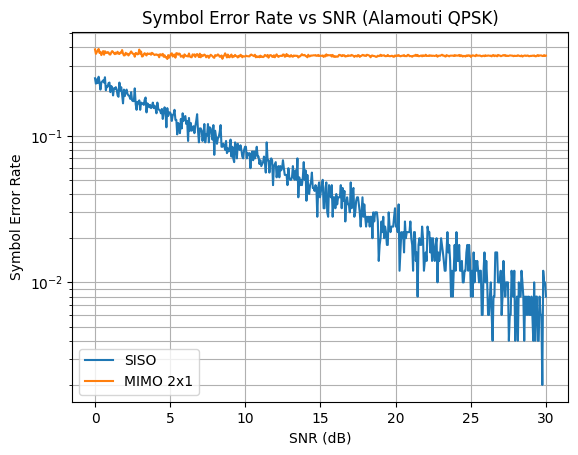

In [60]:
# Scatterer multipath propagation model
# Simulate the performance of Alamouti one-antenna transmit diversity
Nt = 1  # transmit antennas
# calculate an array of channel matrices
H = np.zeros([points, Nt, Nr], dtype=complex)   # channel matrices
for m in range(0,points):
    # calculate the fields
    for n in range(0,Nt):
        # element positions within the tx array
        x_t_e = x_t + n*d
        # distance between scatterer and receiver
        delta_r = np.sqrt((x_t_e - x_s[m])**2 + (y_t - y_s[m])**2) \
                - np.sqrt((x_s[m] - x_r[m])**2 + (y_s[m] - y_r[m])**2) 
        # received field
        H[m, n, 0] = 1+ref_coef*np.exp(-1j*k*delta_r)

# Repeat for different values of SNR
bit_error_rate_2 = [] # number of errors
for SNR in SNRt_dB:
    SNR_linear = 10**(SNR / 10)
    noise_var = 1 / SNR_linear
    noise_std = np.sqrt(noise_var / 2)
    noise = noise_std * (np.random.randn(num_blocks) + 1j * np.random.randn(num_blocks))

    x = np.zeros(num_blocks, dtype=complex)
    y = np.zeros(num_blocks, dtype=complex)

    for m in range(num_blocks):
        s = qpsk_blocks[m, 0]  # Just send one symbol per block
        h = H[m, 0, 0]
        x[m] = h * s + noise[m]
        y[m] = x[m] / h  # Equalize

    # Decode
    errors = 0
    for i in range(num_blocks):
        if not same_quadrant(y[i], qpsk_blocks[i, 0]):
            errors += 1

    bit_error_rate_2.append(errors / num_blocks)

# plot the symbol error rate on a log scale as a function of SNR in dB
plt.semilogy(SNRt_dB, bit_error_rate_2, label='SISO')
plt.semilogy(SNRt_dB, bit_error_rate, label='MIMO 2x1')
plt.title('Symbol Error Rate vs SNR (Alamouti QPSK)')
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Rate')
plt.grid(True, which='both')
plt.legend()
plt.show()
